In [1]:
from process_bigraph import ProcessTypes, Composite, register_types
from process_bigraph.emitter import gather_emitter_results
from cobra.io import load_model, read_sbml_model
from cobra.medium import minimal_medium
from vivaCRM.crm_gsmm_golford import (
    get_crm_goldford_emitter, 
    plot_crm_goldford_simulation)
from CRM.crm_gsmm_goldford_utils import ( 
    extract_yields, 
    extract_byproducts, 
    extract_uptake_rates, 
    run_mcrm_from_extractions, 
    plot_mcrm, 
    build_crm_goldford_config, 
    make_initial_state, 
    extract_yields_agora,
    extract_byproducts_agora,
    extract_uptake_rates_agora)
from vivaCRM.new_crm_gsmm_golford import build_params, MCRM_Process
from cdFBA.utils import get_objective_reaction

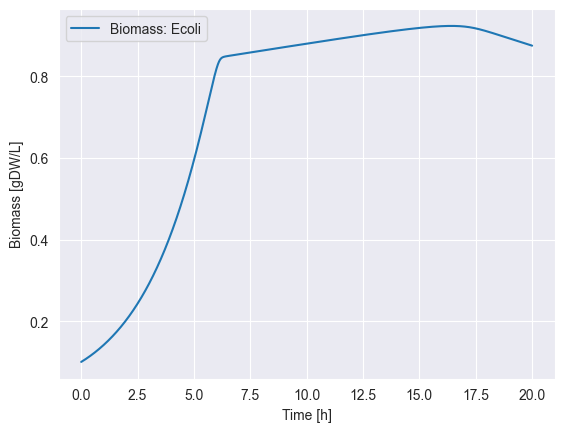

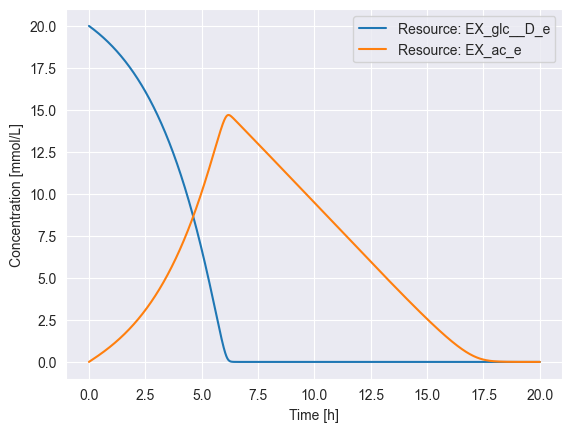

In [2]:
model = load_model("textbook")
resource_ids = ["EX_glc__D_e", "EX_ac_e"]  # choose resources to model

#Extract information from the gsmm file
extractions = {
    "Ecoli": {
        "yields": extract_yields(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                 uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
        "byproducts": extract_byproducts(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                         uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
        "uptakes": extract_uptake_rates(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                        uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
    }
}

# 2) Monod Km per resource
Km = {"EX_glc__D_e": 0.5, "EX_ac_e": 0.5}

# 3) Initial conditions (dicts)
n0 = {"Ecoli": 0.1}
R0 = {"EX_glc__D_e": 20.0, "EX_ac_e": 0.0}

# 4) Simulate
t, X, sp_order, res_order, params = run_mcrm_from_extractions(
    extractions, resource_ids, Km,
    initial_biomass_by_species=n0,
    initial_resources_by_id=R0,
    use_uptake_as_vmax=True,
    dilution=0.0,
    T=20.0, steps=3000,
)

# 5) Plot
plot_mcrm(t, X, sp_order, res_order)

# Vivarium implementation

In [3]:
model = load_model("textbook")
resource_ids = ["EX_glc__D_e", "EX_ac_e"]  # choose resources to model
extractions = {
    "Ecoli": {
        "yields": extract_yields(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                 uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
        "byproducts": extract_byproducts(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                         uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
        "uptakes": extract_uptake_rates(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                        uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
    }
}

# 2) Monod Km per resource
Km = {"EX_glc__D_e": 0.5, "EX_ac_e": 0.5}

# 2) build crm_goldford config
cfg = build_crm_goldford_config(extractions, resource_ids, Km,
                                maintenance_by_species={"Ecoli": 0.02},
                                dilution=0.0,
                                feed_by_resource={}, resource_loss_by_resource={})

# 3) initial state
state0 = make_initial_state(["Ecoli"], resource_ids,
                            n0_by_species={"Ecoli": 0.1},
                            R0_by_resource={"EX_glc__D_e":20.0, "EX_ac_e": 0.0})

In [4]:
# build params
params = build_params(
    cfg['species_names'], cfg['resource_names'],
    yields_map=cfg['yields'],
    vmax_map=cfg['resource_uptakes'],
    maintenance_map=cfg['maintenance'],
    Km_map=cfg['Km'],
    byproducts_map=cfg['byproducts'],
    dilution=cfg['dilution'],
    feed_map=cfg['feed'],
    resource_loss_map=cfg['resource_loss'],
)

In [5]:
adaptive_spec = {
    "adaptive_crm": {
        "_type": "process",
        "address": "local:MCRM_Process",
        "config": {
            "species_names": cfg["species_names"],
            "resource_names": cfg["resource_names"],
            "params": params,
            "method": "RK45",
            "rtol": 1e-5, "atol": 1e-7, "max_step": 0.05,
            "clip_nonnegative": True,
        },
        "inputs": {"species": ["species"], "concentrations": ["concentrations"]},
        "outputs": {"species_delta": ["species"], "concentrations_delta": ["concentrations"]},
        "interval": 0.5,
    }
}

state0 = {
    "species": {"Ecoli": 0.1},
    "concentrations": {"EX_glc__D_e": 20.0, "EX_ac_e": 0.0},
    "global_time": 0.0,
}
spec = {**adaptive_spec, **state0}
state_keys = ["species", "concentrations", "global_time"]
spec["emitter"] = get_crm_goldford_emitter(state_keys)

In [6]:
core = ProcessTypes()
core = register_types(core)
core.register_process("MCRM_Process", MCRM_Process)
sim = Composite({"state": spec}, core=core)

In [7]:
params

MCRMParams(yields=array([[0.03646071, 0.01857921]]), vmax=array([[10.       ,  1.6836817]]), B=array([[[0.       , 0.       ],
        [0.9096579, 0.       ]]]), Km=array([0.5, 0.5]), maintenance=array([0.02]), dilution=0.0, feed=None, resource_loss=array([0., 0.]))

In [8]:
sim.run(20)

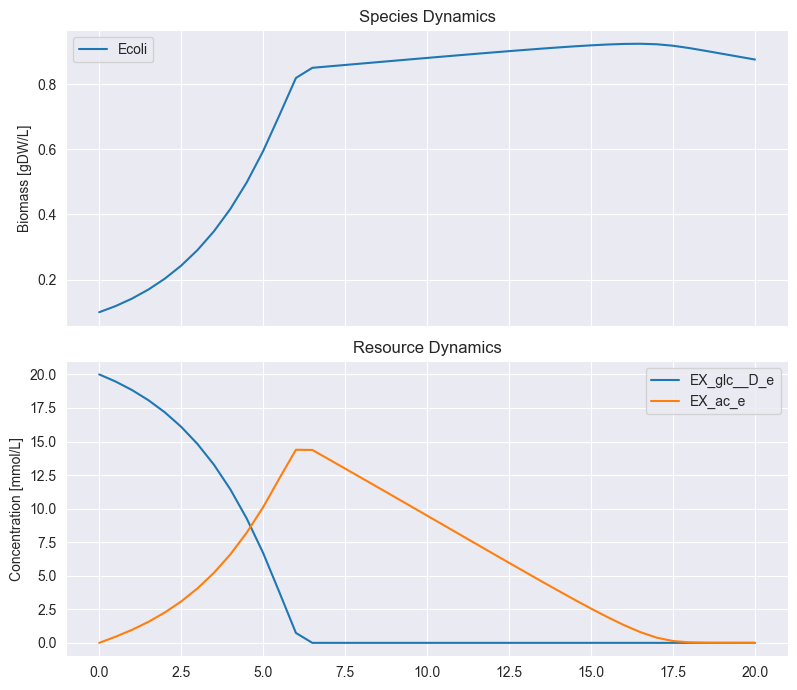

In [9]:
results = gather_emitter_results(sim)[('emitter',)]
plot_crm_goldford_simulation(results)

## To Do -  Implement this with multiple species and volumetric environment

In [10]:
gut_normal = {
    'E_rectale': ('/Users/edwin/Downloads/reconstructions/GSMM/Eubacterium_rectale_ATCC_33656.xml'),
    'B_thetaiotaomicron' : ('/Users/edwin/Downloads/reconstructions/sbml/Bacteroides_thetaiotaomicron_VPI_5482.xml'),
    'Methanobrevibacter_smithii': ('/Users/edwin/Downloads/reconstructions/sbml/Methanobrevibacter_smithii_ATCC_35061.xml')
}

In [11]:
def get_mini_medium(model, target_growth = 10e-4):
    
				## make a copy of the model
    try_model = model.copy()
    
				## compute the minimum media neccessary for growth at targeted_growth
    mini_growth = minimal_medium(try_model,target_growth, minimize_components=10,open_exchanges=True)
    
				## set minimal medium
    mini_medium = {}
    for i in mini_growth.index:
            mini_medium[i] = try_model.medium[i]
            
				## get all other metabolites that can be added to the medium
    additional_medium = try_model.medium
    for i in mini_medium.keys():
            del additional_medium[i]
    return mini_medium, additional_medium

In [12]:
gut_models = {
    "B_thetaiotaomicron": "/Users/edwin/Downloads/reconstructions/sbml/Bacteroides_thetaiotaomicron_VPI_5482.xml",
    "E_rectale": "/Users/edwin/Downloads/reconstructions/GSMM/Eubacterium_rectale_ATCC_33656.xml",
    "Methanobrevibacter_smithii": "/Users/edwin/Downloads/reconstructions/sbml/Methanobrevibacter_smithii_ATCC_35061.xml",
}
models = {k: read_sbml_model(v) for k, v in gut_models.items()}

In [13]:
models

{'B_thetaiotaomicron': <Model Bacteroides_thetaiotaomicron_VPI_5482 at 0x1292a2890>,
 'E_rectale': <Model Eubacterium_rectale_ATCC_33656 at 0x13c2f0110>,
 'Methanobrevibacter_smithii': <Model Methanobrevibacter_smithii_ATCC_35061 at 0x13ba2fd10>}

In [14]:
BT = models["B_thetaiotaomicron"]
ER = models["E_rectale"]
MS = models["Methanobrevibacter_smithii"]

In [15]:
BT_mini_medium = get_mini_medium(BT)[0]
ER_mini_medium = get_mini_medium(ER)[0]
ER_mini_medium["EX_ac(e)"] = 1000

In [16]:
biomass_reaction = get_objective_reaction(model)

In [17]:
biomass_reaction


'Biomass_Ecoli_core'

In [19]:
# --- 0) Load models and set biomass IDs ---
from cobra.io import read_sbml_model

models = {
    "B_thetaiotaomicron": BT,
    "E_rectale": ER,
}
biomass_id = {
    "B_thetaiotaomicron": "EX_biomass(e)",   # set to the exact biomass rxn id in your model
    "E_rectale": "EX_biomass(e)",
}

# --- 1) Exchanges to track (use YOUR IDs exactly) ---
resource_ids = ["EX_hspg(e)", "EX_ac(e)", "EX_but(e)"]

# --- 2) Extract yields, uptakes, byproducts for each species under a unified medium ---
extractions = {
    "B_thetaiotaomicron": {
        "yields":     extract_yields_agora(models["B_thetaiotaomicron"], resource_ids,
                                           biomass_rxn_id=biomass_id["B_thetaiotaomicron"],
                                           use_pfba=False),
        "byproducts": extract_byproducts_agora(models["B_thetaiotaomicron"], resource_ids,
                                               biomass_rxn_id=biomass_id["B_thetaiotaomicron"],
                                               use_pfba=False),
        "uptakes":    extract_uptake_rates_agora(models["B_thetaiotaomicron"], resource_ids,
                                                 biomass_rxn_id=biomass_id["B_thetaiotaomicron"],
                                                 use_pfba=False),
    },
    "E_rectale": {
        "yields":     extract_yields_agora(models["E_rectale"], resource_ids,
                                           biomass_rxn_id=biomass_id["E_rectale"],
                                           use_pfba=False),
        "byproducts": extract_byproducts_agora(models["E_rectale"], resource_ids,
                                               biomass_rxn_id=biomass_id["E_rectale"],
                                               use_pfba=False),
        "uptakes":    extract_uptake_rates_agora(models["E_rectale"], resource_ids,
                                                 biomass_rxn_id=biomass_id["E_rectale"],
                                                 use_pfba=False),
    }
}

# --- 3) Monod Km per resource (tune later) ---
Km = {"EX_hspg(e)": 0.5, "EX_ac(e)": 0.3, "EX_but(e)": 0.2}

# --- 4) Build CRM config (Goldford-style) ---
cfg = build_crm_goldford_config(
    extractions,
    resource_ids,
    Km,
    maintenance_by_species={"B_thetaiotaomicron": 0.02, "E_rectale": 0.02},
    dilution=0.0,
    feed_by_resource={},              # e.g., set EX_hspg(e) here if you run as chemostat (dilution>0)
    resource_loss_by_resource={},     # optional abiotic loss rates per resource
)

# --- 5) Initial state: HSPG present; acetate/butyrate start at 0 ---
state0 = make_initial_state(
    ["B_thetaiotaomicron", "E_rectale"],
    resource_ids,
    n0_by_species={"B_thetaiotaomicron": 0.1, "E_rectale": 0.1},
    R0_by_resource={"EX_hspg(e)": 20.0, "EX_ac(e)": 0.0, "EX_but(e)": 0.0}
)

In [20]:
extractions

{'B_thetaiotaomicron': {'yields': {'EX_hspg(e)': 0.0,
   'EX_ac(e)': 0.0,
   'EX_but(e)': 0.0},
  'byproducts': {'EX_hspg(e)': {'EX_7ocholate(e)': 1000.0,
    'EX_ac(e)': 999.9999999999999,
    'EX_co2(e)': 1000.0,
    'EX_for(e)': 1000.0,
    'EX_galur(e)': 1000.0,
    'EX_gam(e)': 1000.0,
    'EX_gcald(e)': 0.9689290551286049,
    'EX_glcur(e)': 500.00000000000006,
    'EX_h(e)': 1000.0,
    'EX_h2(e)': 237.25023204242763,
    'EX_meoh(e)': 852.2270078666842,
    'EX_nh4(e)': 1000.0,
    'EX_pac(e)': 848.9566683437522,
    'EX_ppa(e)': 996.4472601311955,
    'EX_succ(e)': 909.9567694443306,
    'EX_trp_L(e)': 826.2716602764573,
    'EX_val_L(e)': 431.49813569785},
   'EX_ac(e)': {'EX_7ocholate(e)': 1000.0,
    'EX_ac(e)': 999.9999999999999,
    'EX_co2(e)': 1000.0,
    'EX_for(e)': 1000.0,
    'EX_galur(e)': 1000.0,
    'EX_gam(e)': 1000.0,
    'EX_gcald(e)': 0.9689290551286049,
    'EX_glcur(e)': 500.00000000000006,
    'EX_h(e)': 1000.0,
    'EX_h2(e)': 237.25023204242763,
    'EX_

In [21]:
cfg

{'species_names': ['B_thetaiotaomicron', 'E_rectale'],
 'resource_names': ['EX_hspg(e)', 'EX_ac(e)', 'EX_but(e)'],
 'yields': {'B_thetaiotaomicron': {'EX_hspg(e)': 0.0,
   'EX_ac(e)': 0.0,
   'EX_but(e)': 0.0},
  'E_rectale': {'EX_hspg(e)': 0.0, 'EX_ac(e)': 0.0, 'EX_but(e)': 0.0}},
 'resource_uptakes': {'B_thetaiotaomicron': {'EX_hspg(e)': 0.0,
   'EX_ac(e)': 0.0,
   'EX_but(e)': 0.0},
  'E_rectale': {'EX_hspg(e)': 0.0, 'EX_ac(e)': 0.0, 'EX_but(e)': 0.0}},
 'maintenance': {'B_thetaiotaomicron': 0.02, 'E_rectale': 0.02},
 'Km': {'EX_hspg(e)': 0.5, 'EX_ac(e)': 0.3, 'EX_but(e)': 0.2},
 'byproducts': {'B_thetaiotaomicron': {}, 'E_rectale': {}},
 'dilution': 0.0,
 'feed': {'EX_hspg(e)': 0.0, 'EX_ac(e)': 0.0, 'EX_but(e)': 0.0},
 'resource_loss': {'EX_hspg(e)': 0.0, 'EX_ac(e)': 0.0, 'EX_but(e)': 0.0}}

In [22]:
# build params
params = build_params(
    cfg['species_names'], cfg['resource_names'],
    yields_map=cfg['yields'],
    vmax_map=cfg['resource_uptakes'],
    maintenance_map=cfg['maintenance'],
    Km_map=cfg['Km'],
    byproducts_map=cfg['byproducts'],
    dilution=cfg['dilution'],
    feed_map=cfg['feed'],
    resource_loss_map=cfg['resource_loss'],
)

In [23]:
adaptive_spec = {
    "adaptive_crm": {
        "_type": "process",
        "address": "local:MCRM_Process",
        "config": {
            "species_names": cfg["species_names"],
            "resource_names": cfg["resource_names"],
            "params": params,
            "method": "RK45",
            "rtol": 1e-5, "atol": 1e-7, "max_step": 0.05,
            "clip_nonnegative": True,
        },
        "inputs": {"species": ["species"], "concentrations": ["concentrations"]},
        "outputs": {"species_delta": ["species"], "concentrations_delta": ["concentrations"]},
        "interval": 0.5,
    }
}

In [24]:
spec = {**adaptive_spec, **state0}
state_keys = ["species", "concentrations", "global_time"]
spec["emitter"] = get_crm_goldford_emitter(state_keys)

In [25]:
core = ProcessTypes()
core = register_types(core)
core.register_process("MCRM_Process", MCRM_Process)
sim = Composite({"state": spec}, core=core)

In [26]:
sim.run(20)

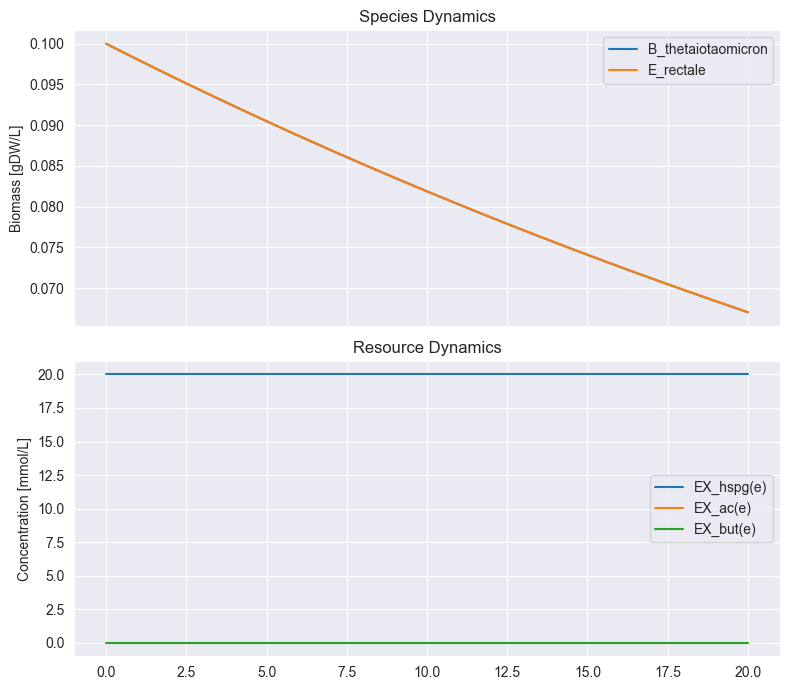

In [27]:
results = gather_emitter_results(sim)[('emitter',)]
plot_crm_goldford_simulation(results)